# Neural Networks
Notebook adapted and inspired from: https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

Tree-based methods are **simple** and **useful for interpretation**. However they typically are not competitive with the best supervised learning approaches in terms of prediction accuracy.

**Bagging**, **Random Forests**, and **boosting** grows multiple trees which are then combined to yield a single consensus prediction. Combining a large number of trees can often result in dramatic improvements in prediction accuracy, at the expense of some loss interpretation.

In [11]:
# some imports
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
#import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Neural Networks

Neural nets are a specific method for learning from data, a method that is based on a very simple element, the *neuron unit*. A neuron unit (or 1-layer neural network) is a mathematical function of this kind:

${\mathbf y} = \sigma(\mathbf{w}^T \cdot {\mathbf x} + b)$

where ${\mathbf x}$ represents an input element in vector form, $\mathbf{w}$ is a vector of weights,  $\sigma$ is a non-linear function and $b$ a scalar value. $(\mathbf{w},b)$ are called the parameters of the function. The output of this function is called the *activation* of the neuron. 

Regarding the non-linear function, historically the most common one was the Sigmoid function, but nowadays there are several alternatives that are supposed to be better suited to learning from data, such as ReLU and variants.

> **Q:** What kind of decision functions are represented by a 1-layer nn?

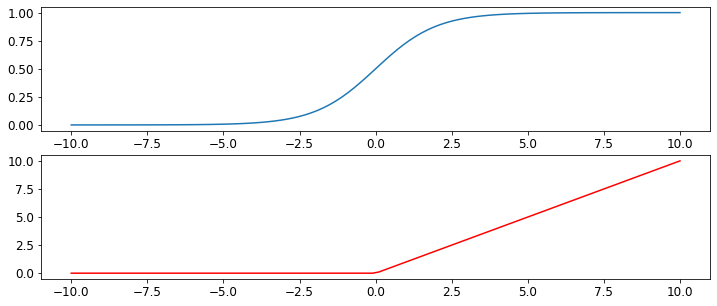

In [12]:
import numpy as np
import matplotlib.pylab as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return x * (x > 0)

plt.ylim(-1.5, 10)
x = np.linspace(-10.0,10.0,100)
y1 = sigmoid(x)
plt.subplot(2, 1, 1)
plt.plot(x,y1)
y2 = ReLU(x)
plt.subplot(2, 1, 2)
plt.plot(x,y2,'r')

In [13]:
x = np.array([0.4,1.2,3.5])

w = np.array([1.0,2.0,1.0])
b = 1.3

y = sigmoid(np.dot(x,w) + b)

print(y)

0.9994997988929205


## Multilayer neural networks

Simple neurons can be organized in larger structures by applying to the same data vector different sets of weights, forming what is called a *layer*, and by stacking layers one on top of the output of the other.  

It is important to notice that a multilayer neural network can be seen as a composition of matrix products (matrices represent weights) and non-linear function activations. For the case of a 2-layer network the outcome is:

$ {\mathbf y} = {\mathbf \sigma}\Big( W^1  {\mathbf \sigma}\Big( W^0  {\mathbf x} + {\mathbf b}^0 \Big) + {\mathbf b}^1 \Big)$

where ${\mathbf \sigma}$ represents a vectorial version of the sigmoid function and $W^i$ are the weights of each layer in matrix form.  

What is interesting about this kind of structures is that it has been showed that even a neural network with a single hidden layer containing a finite number of neurons can approximate any continuous function of $\mathbf{R}^n$. This fact makes neural networks a sound candidate to implement learning from data methods. The question is then: how to find the optimal parameters, ${\mathbf w} = (W^i,{\mathbf b})$, to approximate a function that is implicitly defined by a set of samples $\{({\mathbf x}_1, {\mathbf y}_1), \dots,  ({\mathbf x}_n, {\mathbf y}_n)\}$?

From a technical point of view, not only neural networks but most of the algorithms that have been proposed to infer models from large data sets are based on the iterative solution of a mathematical problem that involves data and a mathematical model. If there was an analytic solution to the problem, this should be the adopted one, but this is not the case for most of the cases. The techniques that have been designed to tackle these problems are grouped under a field that is called optimization. The most important technique for solving optimization problems is *gradient descend*.

> The training of models like $ {\mathbf y} = {\mathbf \sigma}\Big( W^1  {\mathbf \sigma}\Big( W^0  {\mathbf x} + {\mathbf b}^0 \Big) + {\mathbf b}^1 \Big)$ (or bigger!) can be readily performed by applying *automatic differentiation* to a loss function. 

> In the case of regression: $L = \frac{1}{n} \sum_{i=1}^n \Big({\mathbf y}_i - {\mathbf \sigma}\Big( W^1  {\mathbf \sigma}\Big( W^0  {\mathbf x}_i + {\mathbf b}^0 \Big) + {\mathbf b}^1 )\Big)\Big)^2 $

> In the case of two-class classification: $L = \frac{1}{n} log(1 + exp(-y_i {\mathbf \sigma}\Big( W^1  {\mathbf \sigma}\Big( W^0  {\mathbf x} + {\mathbf b}^0 \Big) + {\mathbf b}^1 \Big))) $


## Playing with neural nets.
+ Concentric classes, 1 layer, Sigmoid.
+ Concentric classes, 1 layer, ReLu.
+ X-or, 0 layer.
+ X-or, 1 layer.
+ Spiral data.
+ Regression.


http://playground.tensorflow.org

# Deep Learning in `keras`

> Keras is a high-level neural networks library, written in Python and capable of running on top TensorFlow. It was developed with a focus on enabling fast experimentation.

The core data structure of Keras is a model, a way to organize layers. The main type of model is the ``Sequential model``, a linear stack of layers. 

```Python
from keras.models import Sequential
model = Sequential()
```

Stacking layers is as easy as ``.add()``:

```Python
from keras.layers import Dense, Activation

model.add(Dense(output_dim=64, input_dim=100))
model.add(Activation("relu"))
model.add(Dense(output_dim=10))
model.add(Activation("softmax"))
```

Once your model looks good, configure its learning process with ``.compile()``:

```Python
model.compile(loss='categorical_crossentropy', 
              optimizer='sgd', metrics=['accuracy'])
```

If you need to, you can further configure your optimizer.

```Python
from keras.optimizers import SGD
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True))
```

You can now iterate on your training data in batches:

```Python
model.fit(X_train, Y_train, nb_epoch=5, batch_size=32)
```

Evaluate your performance in one line:
```Python
loss_and_metrics = model.evaluate(X_test, Y_test, batch_size=32)
```

Or generate predictions on new data:

```Python
classes = model.predict_classes(X_test, batch_size=32)
proba = model.predict_proba(X_test, batch_size=32)
```

In [14]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [15]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16365307228471508508]

## Building an image classifier with keras

In [16]:
from tensorflow import keras
keras.__version__


'2.2.4-tf'

In [17]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [18]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):



In [19]:
X_train_full.dtype

dtype('uint8')


Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [20]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's imshow() function, with a 'binary' color map:

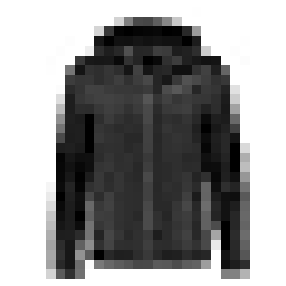

In [21]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [22]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [23]:
# Here are the corresponding class names:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# The first image in the training set is a coat:
print(class_names[y_train[0]])

Coat


In [24]:
# The validation set contains 5,000 images, and the test set contains 10,000 images:
print(X_valid.shape)

(5000, 28, 28)


In [25]:
# The test set contains 5,000 images, and the test set contains 10,000 images:
print(X_test.shape)

(10000, 28, 28)


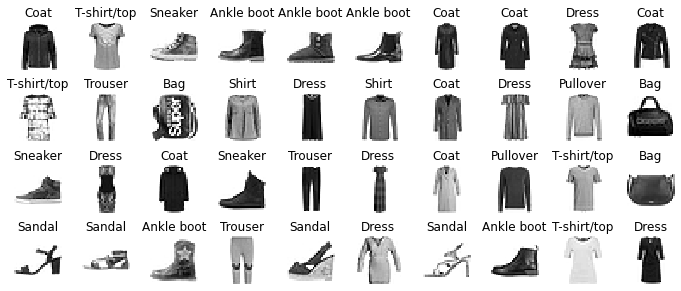

In [26]:
# Let's take a look at a sample of the images in the dataset:

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [27]:
# clear previous session
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
# Let's create a classification model for this problem
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

# Option 2
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [29]:
model.layers

In [30]:
# How many parameters does the model have? Think about it

In [31]:
# model.summary()

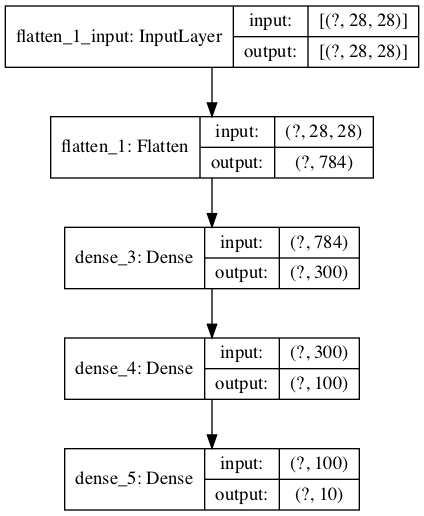

In [32]:
#we can plot the model using the following funcition
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

#if it does not work, perhaps some packages need to be installed:
#!conda install -y graphviz
#!conda install -y pydot

In [34]:
# lets define our loss function, optimizer and accuracy metrics
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

this is equivalent to
```python

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])

```

In [36]:
# let's train the classifier for 5 epochs
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 4s 80us/sample - loss: 0.4521 - accuracy: 0.8406 - val_loss: 0.4420 - val_accuracy: 0.8490
Epoch 2/5
55000/55000 [==============================] - 4s 78us/sample - loss: 0.4216 - accuracy: 0.8527 - val_loss: 0.4109 - val_accuracy: 0.8554
Epoch 3/5
55000/55000 [==============================] - 4s 80us/sample - loss: 0.3992 - accuracy: 0.8601 - val_loss: 0.3879 - val_accuracy: 0.8656
Epoch 4/5
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3838 - accuracy: 0.8668 - val_loss: 0.3714 - val_accuracy: 0.8716
Epoch 5/5
55000/55000 [==============================] - 4s 79us/sample - loss: 0.3698 - accuracy: 0.8710 - val_loss: 0.3756 - val_accuracy: 0.8720


In [ ]:
history.params

In [37]:
print(history.epoch)


[0, 1, 2, 3, 4]


In [38]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

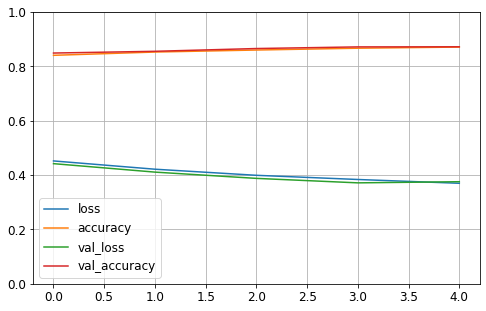

In [39]:
# it is important to plot the training curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [48]:
# let's evaluate the test set. 
model.evaluate(X_test, y_test,verbose=2)

10000/1 - 0s - loss: 0.3438 - accuracy: 0.8507


[0.4154003119468689, 0.8507]

In [69]:
range(y_proba[0].shape[0])

range(0, 10)

[0.   0.   0.   0.   0.   0.07 0.   0.09 0.   0.84]


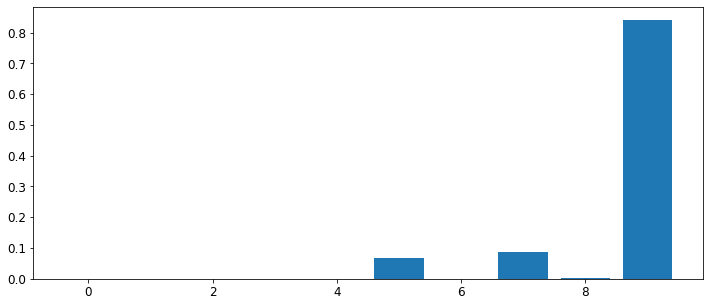

In [73]:
# we can evaluate on sample
X_new = X_test[:1]
y_proba = model.predict(X_new)[0]
print(y_proba.round(2))
plt.bar(range(y_proba.shape[0]),y_proba)
plt.show()

In [76]:
# if we want to test several examples

X_new = X_test[:3]
y_proba = model.predict(X_new)
print(y_proba.round(2))

y_pred = model.predict_classes(X_new)
print("\nclass predixtions", y_pred)

[[0.   0.   0.   0.   0.   0.07 0.   0.09 0.   0.84]
 [0.   0.   0.94 0.   0.01 0.   0.04 0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]]

class predixtions [9 2 1]


Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 5s 89us/sample - loss: 0.7312 - accuracy: 0.7577 - val_loss: 0.5321 - val_accuracy: 0.8196
Epoch 2/5
55000/55000 [==============================] - 4s 80us/sample - loss: 0.4906 - accuracy: 0.8289 - val_loss: 0.4611 - val_accuracy: 0.8416
Epoch 3/5
55000/55000 [==============================] - 4s 80us/sample - loss: 0.4428 - accuracy: 0.8438 - val_loss: 0.4239 - val_accuracy: 0.8564
Epoch 4/5
55000/55000 [==============================] - 4s 79us/sample - loss: 0.4173 - accuracy: 0.8529 - val_loss: 0.3950 - val_accuracy: 0.8628
Epoch 5/5
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3969 - accuracy: 0.8594 - val_loss: 0.4083 - val_accuracy: 0.8562


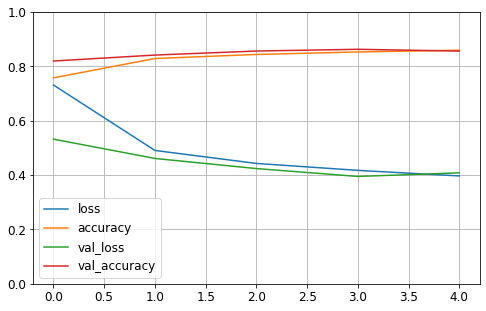

10000/1 - 0s - loss: 0.3599 - accuracy: 0.8370


[0.4488424150943756, 0.837]

In [77]:
# Let's put everything in one cell:

# create the model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

# define loss function, optimizer and metrics
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

# train the model and validate using val data
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

# plot training curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# evaluate the model using test data
model.evaluate(X_test, y_test,verbose=2)

## Regression with MLP

In [80]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [81]:
np.random.seed(42)
tf.random.set_seed(42)

Train on 11610 samples, validate on 3870 samples
Epoch 1/15
11610/11610 [==============================] - 1s 60us/sample - loss: 2.1513 - val_loss: 3.4754
Epoch 2/15
11610/11610 [==============================] - 0s 33us/sample - loss: 0.7966 - val_loss: 0.7365
Epoch 3/15
11610/11610 [==============================] - 0s 33us/sample - loss: 0.6877 - val_loss: 0.6546
Epoch 4/15
11610/11610 [==============================] - 0s 33us/sample - loss: 0.6432 - val_loss: 0.6170
Epoch 5/15
11610/11610 [==============================] - 0s 33us/sample - loss: 0.6099 - val_loss: 0.6156
Epoch 6/15
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5806 - val_loss: 0.5530
Epoch 7/15
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5582 - val_loss: 0.5374
Epoch 8/15
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5387 - val_loss: 0.5140
Epoch 9/15
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5225 - val_l

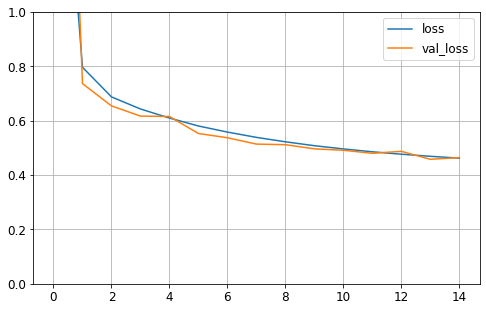

Evaluating test set
5160/1 - 0s - loss: 0.3834


0.44509506197862847

In [89]:
# create the model
model = keras.models.Sequential()
model.add(keras.layers.Dense(30, activation="relu",input_shape=X_train.shape[1:]))
model.add(keras.layers.Dense(1))

# define loss function, optimizer and metrics
model.compile(loss="mean_squared_error", 
              optimizer=keras.optimizers.SGD(lr=1e-3))


# train the model and validate using val data
history = model.fit(X_train, y_train, epochs=15,
                    validation_data=(X_valid, y_valid))

# plot training curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# evaluate the model using test data
print("Evaluating test set")
model.evaluate(X_test, y_test,verbose=2)

### Dropout

Dropout is a way to regularize the neural network. During training, it may happen that neurons of a particular layer may always become influenced only by the output of a particular neuron in the previous layer. In that case, the neural network would overfit.

Dropout prevents overfitting and regularizes by randomly cutting the connections (also known as dropping the connection) between neurons in successecutive layers during training.

### Keras optimizers

There are several variants of gradient descent, which differ in how we compute the step.

Keras supports seven optimizers.

```python
my_opt = K.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
my_opt = K.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
my_opt = K.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
my_opt = K.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
my_opt = K.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
my_opt = K.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
my_opt = K.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
```

#### Momentum

For example, SGD has trouble navigating ravines, i.e. areas where the surface curves much more steeply in one dimension than in another, which are common around local optima. In these scenarios, SGD oscillates across the slopes of the ravine while only making hesitant progress along the bottom towards the local optimum.

**Momentum** is a method that helps accelerate SGD in the relevant direction and dampens oscillations. It does this by adding a fraction of the update vector of the past time step to the current update vector:

$$ v_t = m v_{t-1} + \alpha \nabla_w f $$$$ w = w - v_t    $$

The momentum $m$ is commonly set to $0.9$.

#### Adagrad

SGD manipulates the learning rate globally and equally for all parameters. Tuning the learning rates is an expensive process, so much work has gone into devising methods that can adaptively tune the learning rates, and even do so per parameter.

Adagrad is an algorithm for gradient-based optimization that does just this: It adapts the learning rate to the parameters, performing larger updates for infrequent and smaller updates for frequent parameters.

$$ c = c + (\nabla_w f)^2 $$$$ w = w - \frac{\alpha}{\sqrt{c}} $$

## Saving and Restoring

Training a Neural Network can take a lot of time. Saving and restoring the model could be really important

In [91]:
np.random.seed(42)
tf.random.set_seed(42)

In [99]:
# we create and train a model

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])



model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test,verbose=2)

model.save("my_keras_model.h5")

Train on 11610 samples, validate on 3870 samples
Epoch 1/5
11610/11610 [==============================] - 1s 67us/sample - loss: 1.4802 - val_loss: 0.6835
Epoch 2/5
11610/11610 [==============================] - 0s 37us/sample - loss: 0.6592 - val_loss: 0.6018
Epoch 3/5
11610/11610 [==============================] - 0s 37us/sample - loss: 0.6000 - val_loss: 0.6100
Epoch 4/5
11610/11610 [==============================] - 0s 38us/sample - loss: 0.5596 - val_loss: 0.5444
Epoch 5/5
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5267 - val_loss: 0.5294
5160/1 - 0s - loss: 0.4665


In [106]:


model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

print(model.predict(X_new))

model = keras.models.load_model("my_keras_model.h5")
print('\nloading model...')
print(model.predict(X_new))
mse_test = model.evaluate(X_test, y_test,verbose=2)


[[-0.24248162]
 [ 0.12465069]
 [ 0.1301432 ]]

loading model...
[[0.91770935]
 [1.4000721 ]
 [2.7654226 ]]
5160/1 - 0s - loss: 0.4665


In [107]:
# this is the samle
model.save_weights("my_keras_weights.ckpt")
model.load_weights("my_keras_weights.ckpt")


### Using Callbacks during Training

In [137]:

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Train on 11610 samples, validate on 3870 samples
Epoch 1/5
11610/11610 [==============================] - 1s 71us/sample - loss: 1.8631 - val_loss: 3.2403
Epoch 2/5
11610/11610 [==============================] - 0s 39us/sample - loss: 0.6723 - val_loss: 0.6939
Epoch 3/5
11610/11610 [==============================] - 0s 39us/sample - loss: 0.5927 - val_loss: 0.5531
Epoch 4/5
11610/11610 [==============================] - 0s 39us/sample - loss: 0.5550 - val_loss: 0.5519
Epoch 5/5
11610/11610 [==============================] - 0s 38us/sample - loss: 0.5278 - val_loss: 0.5715


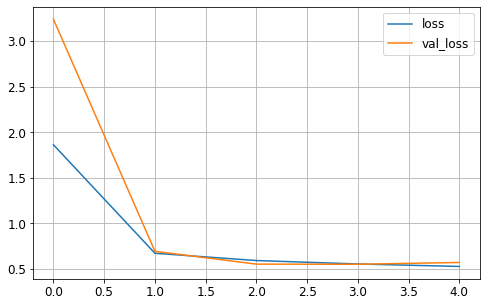

5160/1 - 0s - loss: 0.4558


In [138]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

# define a call back
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)


history = model.fit(X_train, y_train, epochs=5, 
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])

# plot training curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

mse_test = model.evaluate(X_test, y_test,verbose=2)

In [139]:
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test, verbose = 2)

5160/1 - 0s - loss: 0.4839


Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 112us/sample - loss: 1.7004 - val_loss: 0.7751
Epoch 2/100
11610/11610 [==============================] - 1s 66us/sample - loss: 0.7124 - val_loss: 0.6432
Epoch 3/100
11610/11610 [==============================] - 1s 67us/sample - loss: 0.6399 - val_loss: 0.6103
Epoch 4/100
11610/11610 [==============================] - 1s 66us/sample - loss: 0.5924 - val_loss: 0.5547
Epoch 5/100
11610/11610 [==============================] - 1s 65us/sample - loss: 0.5534 - val_loss: 0.5269
Epoch 6/100
11610/11610 [==============================] - 1s 65us/sample - loss: 0.5197 - val_loss: 0.4813
Epoch 7/100
11610/11610 [==============================] - 1s 65us/sample - loss: 0.4932 - val_loss: 0.4557
Epoch 8/100
11610/11610 [==============================] - 1s 65us/sample - loss: 0.4717 - val_loss: 0.4364
Epoch 9/100
11610/11610 [==============================] - 1s 65us/sample - loss: 0.45

Epoch 76/100
11610/11610 [==============================] - 1s 64us/sample - loss: 0.3245 - val_loss: 0.3515
Epoch 77/100
11610/11610 [==============================] - 1s 65us/sample - loss: 0.3243 - val_loss: 0.3113
Epoch 78/100
11610/11610 [==============================] - 1s 64us/sample - loss: 0.3235 - val_loss: 0.3597
Epoch 79/100
11610/11610 [==============================] - 1s 65us/sample - loss: 0.3235 - val_loss: 0.3298
Epoch 80/100
11610/11610 [==============================] - 1s 64us/sample - loss: 0.3228 - val_loss: 0.3796
Epoch 81/100
11610/11610 [==============================] - 1s 65us/sample - loss: 0.3227 - val_loss: 0.3104
Epoch 82/100
11610/11610 [==============================] - 1s 65us/sample - loss: 0.3220 - val_loss: 0.3525
Epoch 83/100
11610/11610 [==============================] - 1s 65us/sample - loss: 0.3220 - val_loss: 0.3166
Epoch 84/100
11610/11610 [==============================] - 1s 64us/sample - loss: 0.3214 - val_loss: 0.3431
Epoch 85/100
11610/

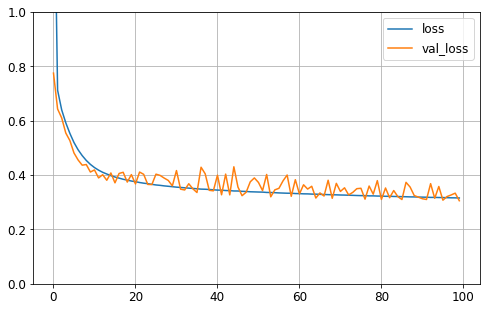

5160/1 - 0s - loss: 0.2288
0.3252563142730284


In [140]:
model = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=[8]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

# define a call back
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)


history = model.fit(X_train, y_train, epochs=100, 
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])

# plot training curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test, verbose = 2)
print(mse_test)

### Early stopping

In [142]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test, verbose = 2)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 103us/sample - loss: 0.3153 - val_loss: 0.3741
Epoch 2/100
11610/11610 [==============================] - 1s 68us/sample - loss: 0.3154 - val_loss: 0.3052
Epoch 3/100
11610/11610 [==============================] - 1s 67us/sample - loss: 0.3148 - val_loss: 0.3147
Epoch 4/100
11610/11610 [==============================] - 1s 68us/sample - loss: 0.3145 - val_loss: 0.3268
Epoch 5/100
11610/11610 [==============================] - 1s 66us/sample - loss: 0.3142 - val_loss: 0.3032
Epoch 6/100
11610/11610 [==============================] - 1s 66us/sample - loss: 0.3139 - val_loss: 0.3594
Epoch 7/100
11610/11610 [==============================] - 1s 66us/sample - loss: 0.3135 - val_loss: 0.3031
Epoch 8/100
11610/11610 [==============================] - 1s 65us/sample - loss: 0.3132 - val_loss: 0.3990
Epoch 9/100
11610/11610 [==============================] - 1s 65us/sample - loss: 0.31

### Exercice
Create a netwerok that achieves at least a 90% accuracy with fashion MNIST.

Train on 55000 samples, validate on 5000 samples
Epoch 1/150
55000/55000 [==============================] - 5s 88us/sample - loss: 0.8438 - accuracy: 0.7117 - val_loss: 0.5649 - val_accuracy: 0.7984
Epoch 2/150
55000/55000 [==============================] - 4s 79us/sample - loss: 0.5255 - accuracy: 0.8145 - val_loss: 0.5013 - val_accuracy: 0.8226
Epoch 3/150
55000/55000 [==============================] - 4s 75us/sample - loss: 0.4660 - accuracy: 0.8346 - val_loss: 0.4459 - val_accuracy: 0.8414
Epoch 4/150
55000/55000 [==============================] - 4s 74us/sample - loss: 0.4363 - accuracy: 0.8444 - val_loss: 0.4079 - val_accuracy: 0.8570
Epoch 5/150
55000/55000 [==============================] - 4s 74us/sample - loss: 0.4145 - accuracy: 0.8530 - val_loss: 0.4260 - val_accuracy: 0.8448
Epoch 6/150
55000/55000 [==============================] - 4s 74us/sample - loss: 0.3981 - accuracy: 0.8576 - val_loss: 0.3934 - val_accuracy: 0.8604
Epoch 7/150
55000/55000 [==========================

Epoch 55/150
55000/55000 [==============================] - 4s 75us/sample - loss: 0.2092 - accuracy: 0.9242 - val_loss: 0.3253 - val_accuracy: 0.8846
Epoch 56/150
55000/55000 [==============================] - 4s 75us/sample - loss: 0.2075 - accuracy: 0.9233 - val_loss: 0.3320 - val_accuracy: 0.8856
Epoch 57/150
55000/55000 [==============================] - 4s 75us/sample - loss: 0.2062 - accuracy: 0.9239 - val_loss: 0.3247 - val_accuracy: 0.8902
Epoch 58/150
55000/55000 [==============================] - 4s 75us/sample - loss: 0.2036 - accuracy: 0.9250 - val_loss: 0.3136 - val_accuracy: 0.8906
Epoch 59/150
55000/55000 [==============================] - 4s 75us/sample - loss: 0.2028 - accuracy: 0.9256 - val_loss: 0.3315 - val_accuracy: 0.8872
Epoch 60/150
55000/55000 [==============================] - 4s 75us/sample - loss: 0.2000 - accuracy: 0.9269 - val_loss: 0.3244 - val_accuracy: 0.8900
Epoch 61/150
55000/55000 [==============================] - 4s 76us/sample - loss: 0.2009 - ac

55000/55000 [==============================] - 4s 77us/sample - loss: 0.1405 - accuracy: 0.9487 - val_loss: 0.3921 - val_accuracy: 0.8846
Epoch 110/150
55000/55000 [==============================] - 4s 76us/sample - loss: 0.1401 - accuracy: 0.9484 - val_loss: 0.3736 - val_accuracy: 0.8882
Epoch 111/150
55000/55000 [==============================] - 4s 75us/sample - loss: 0.1404 - accuracy: 0.9479 - val_loss: 0.3652 - val_accuracy: 0.8944
Epoch 112/150
55000/55000 [==============================] - 4s 75us/sample - loss: 0.1384 - accuracy: 0.9496 - val_loss: 0.4108 - val_accuracy: 0.8832
Epoch 113/150
55000/55000 [==============================] - 4s 75us/sample - loss: 0.1360 - accuracy: 0.9512 - val_loss: 0.3920 - val_accuracy: 0.8864
Epoch 114/150
55000/55000 [==============================] - 4s 75us/sample - loss: 0.1363 - accuracy: 0.9498 - val_loss: 0.4166 - val_accuracy: 0.8700
Epoch 115/150
55000/55000 [==============================] - 4s 76us/sample - loss: 0.1353 - accuracy:

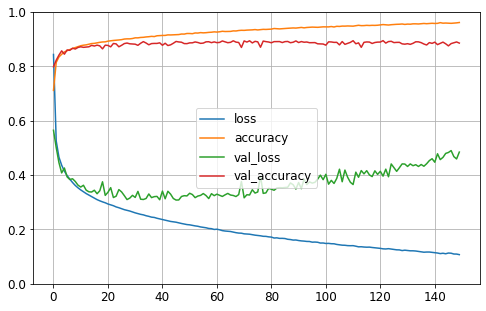

10000/1 - 0s - loss: 0.6953 - accuracy: 0.8763


[0.5307623108625412, 0.8763]

In [149]:
# data
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.


# create the model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(50, activation="relu"))
model.add(keras.layers.Dense(50, activation="relu"))
model.add(keras.layers.Dense(50, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

# define loss function, optimizer and metrics
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

# train the model and validate using val data
history = model.fit(X_train, y_train, epochs=150,
                    validation_data=(X_valid, y_valid))

# plot training curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# evaluate the model using test data
model.evaluate(X_test, y_test,verbose=2)